In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

liquid_triplets_df = pd.read_csv('../data/liquid_triplets_series_flat.csv')
butterfly_zcored = pd.read_csv('../data/butterfly_zcored.csv')

In [3]:
butterfly_zcored.dropna(inplace=True)
liquid_triplets_df.dropna(inplace=True)

In [4]:
butterfly_zcored['timestamp'] = pd.to_datetime(butterfly_zcored['timestamp'])


In [ ]:
import pandas as pd
import numpy as np

def butterfly_trading_strategy(
    butterfly_zcored,
    entry_threshold=2.0,
    exit_threshold=0.5,
    max_holding_period=1440,
    transaction_cost_pct=0.0004,
    notional_per_leg=1_000_000,
    min_tau_threshold=60,  
    zscore_col='fly_value_zscore',
    price_col='fly_value'
):
    trades = []

    for triplet_key in butterfly_zcored[['tenor1_contract', 'tenor2_contract', 'tenor3_contract']].drop_duplicates().values:
        t1, t2, t3 = triplet_key

        triplet_data = butterfly_zcored[
            (butterfly_zcored['tenor1_contract'] == t1) &
            (butterfly_zcored['tenor2_contract'] == t2) &
            (butterfly_zcored['tenor3_contract'] == t3)
        ].copy().sort_values('timestamp').reset_index(drop=True)

        if len(triplet_data) < 2:
            continue

        triplet_data['entry_signal'] = 0
        triplet_data.loc[triplet_data[zscore_col] > entry_threshold, 'entry_signal'] = -1
        triplet_data.loc[triplet_data[zscore_col] < -entry_threshold, 'entry_signal'] = 1
        triplet_data['entry_signal'] = triplet_data['entry_signal'].shift(1)

        position = 0
        entry_idx = None
        entry_time = None
        entry_price = None
        entry_zscore = None

        for idx, row in triplet_data.iterrows():
            current_zscore = row[zscore_col]
            current_time = row['timestamp']
            current_price = row[price_col]
            tau1 = row.get('tau1', np.inf)
            tau2 = row.get('tau2', np.inf)
            tau3 = row.get('tau3', np.inf)
            min_tau = min(tau1, tau2, tau3)

            if pd.isna(current_zscore):
                continue

            if position == 0 and pd.notna(row['entry_signal']) and row['entry_signal'] != 0:
                if (current_price is None or np.isnan(current_price) or abs(current_price) < 1e-8):
                    continue
                if min_tau < min_tau_threshold:
                    continue
                position = int(row['entry_signal'])  
                entry_idx = idx
                entry_time = current_time
                entry_price = current_price
                entry_zscore = current_zscore
                continue 

            if position != 0:
                holding_minutes = (current_time - entry_time).total_seconds() / 60
                if min_tau < min_tau_threshold:
                    should_exit = True
                    exit_reason = "near_expiry"
                elif ((position == 1 and current_zscore > -exit_threshold) or
                      (position == -1 and current_zscore < exit_threshold)):
                    should_exit = True
                    exit_reason = "mean_reversion"
                elif holding_minutes >= max_holding_period:
                    should_exit = True
                    exit_reason = "time_limit"
                elif ((position == 1 and current_zscore < entry_zscore - 1.0) or
                      (position == -1 and current_zscore > entry_zscore + 1.0)):
                    should_exit = True
                    exit_reason = "stop_loss"
                else:
                    should_exit = False
                    exit_reason = ""

                if should_exit:
                    if (current_price is None or np.isnan(current_price) or abs(current_price) < 1e-8):
                        position = 0
                        entry_idx = None
                        entry_time = None
                        entry_price = None
                        entry_zscore = None
                        continue

                    price_change = current_price - entry_price
                    gross_pnl = position * price_change * notional_per_leg / abs(entry_price)
                    total_notional = 3 * notional_per_leg
                    transaction_costs = 2 * transaction_cost_pct * total_notional
                    net_pnl = gross_pnl - transaction_costs

                    trades.append({
                        'tenor1_contract': t1,
                        'tenor2_contract': t2,
                        'tenor3_contract': t3,
                        'entry_time': entry_time,
                        'exit_time': current_time,
                        'position': position,
                        'entry_zscore': entry_zscore,
                        'exit_zscore': current_zscore,
                        'entry_price': entry_price,
                        'exit_price': current_price,
                        'gross_pnl': gross_pnl,
                        'transaction_costs': transaction_costs,
                        'pnl': net_pnl,
                        'notional_per_leg': notional_per_leg,
                        'holding_minutes': holding_minutes,
                        'exit_reason': exit_reason
                    })

                    position = 0
                    entry_idx = None
                    entry_time = None
                    entry_price = None
                    entry_zscore = None

    return pd.DataFrame(trades)


<Figure size 1400x800 with 0 Axes>

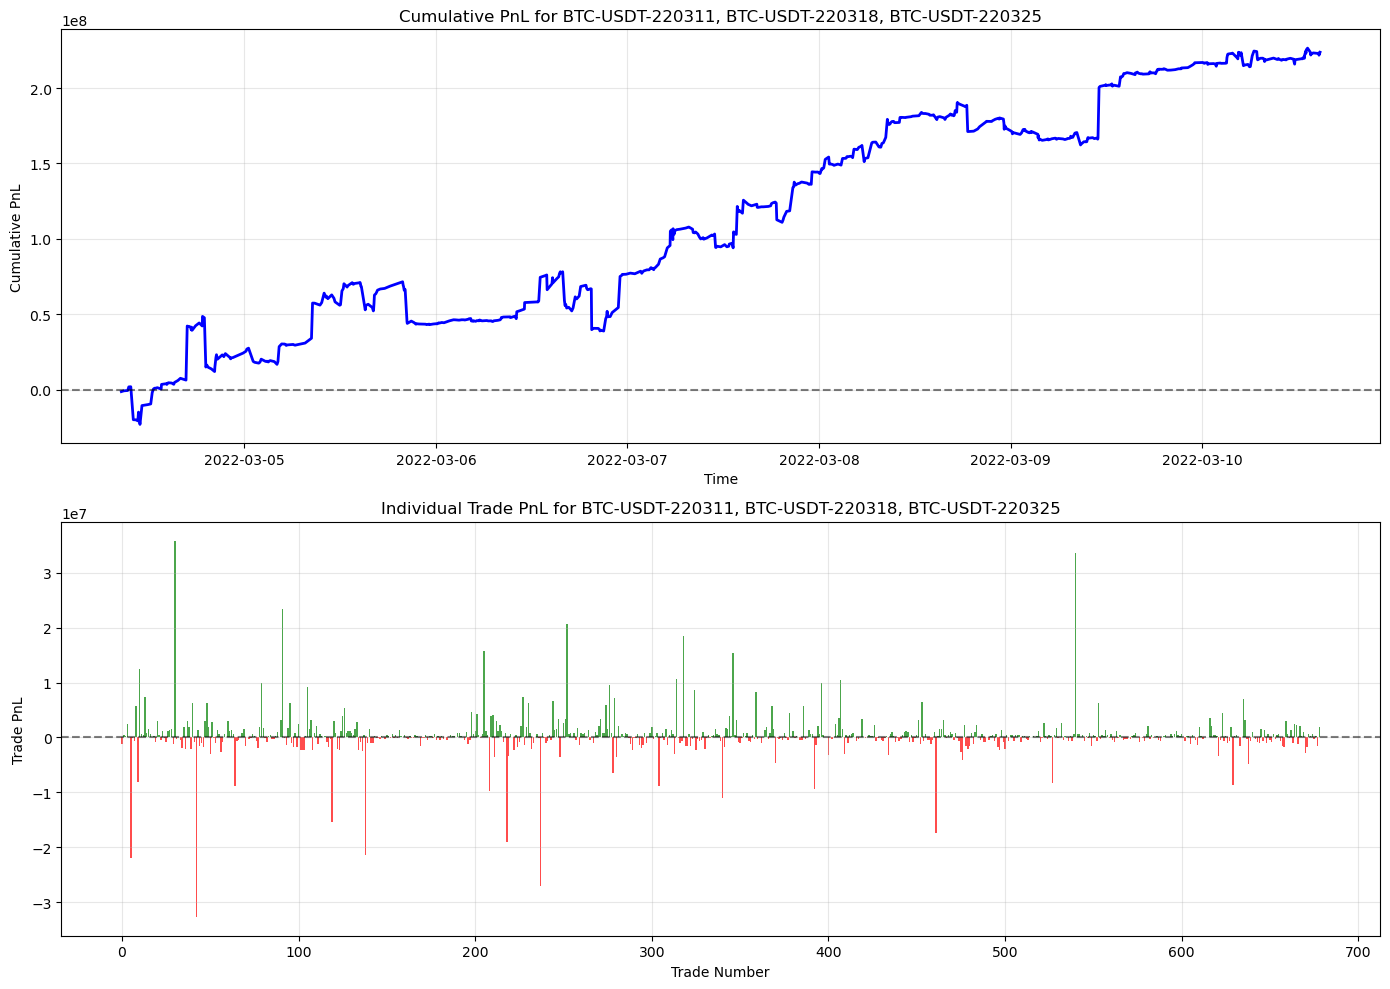

Statistics for BTC-USDT-220311, BTC-USDT-220318, BTC-USDT-220325:
  triplet: BTC-USDT-220311_BTC-USDT-220318_BTC-USDT-220325
  total_trades: 679
  total_pnl: 223742752.3739
  win_rate: 0.5920
  avg_pnl: 329518.0447
  ann_trade_sharpe: 1.5540
  mean_reversion_time: 0.8865
  median_reversion_time: 0.0000
  failure_rate: 0.3122
  avg_move: 1.6710
  avg_mae: -0.0912
  avg_mfe: -0.0364
  avg_edge_per_bar: 108351.1805



<Figure size 1400x800 with 0 Axes>

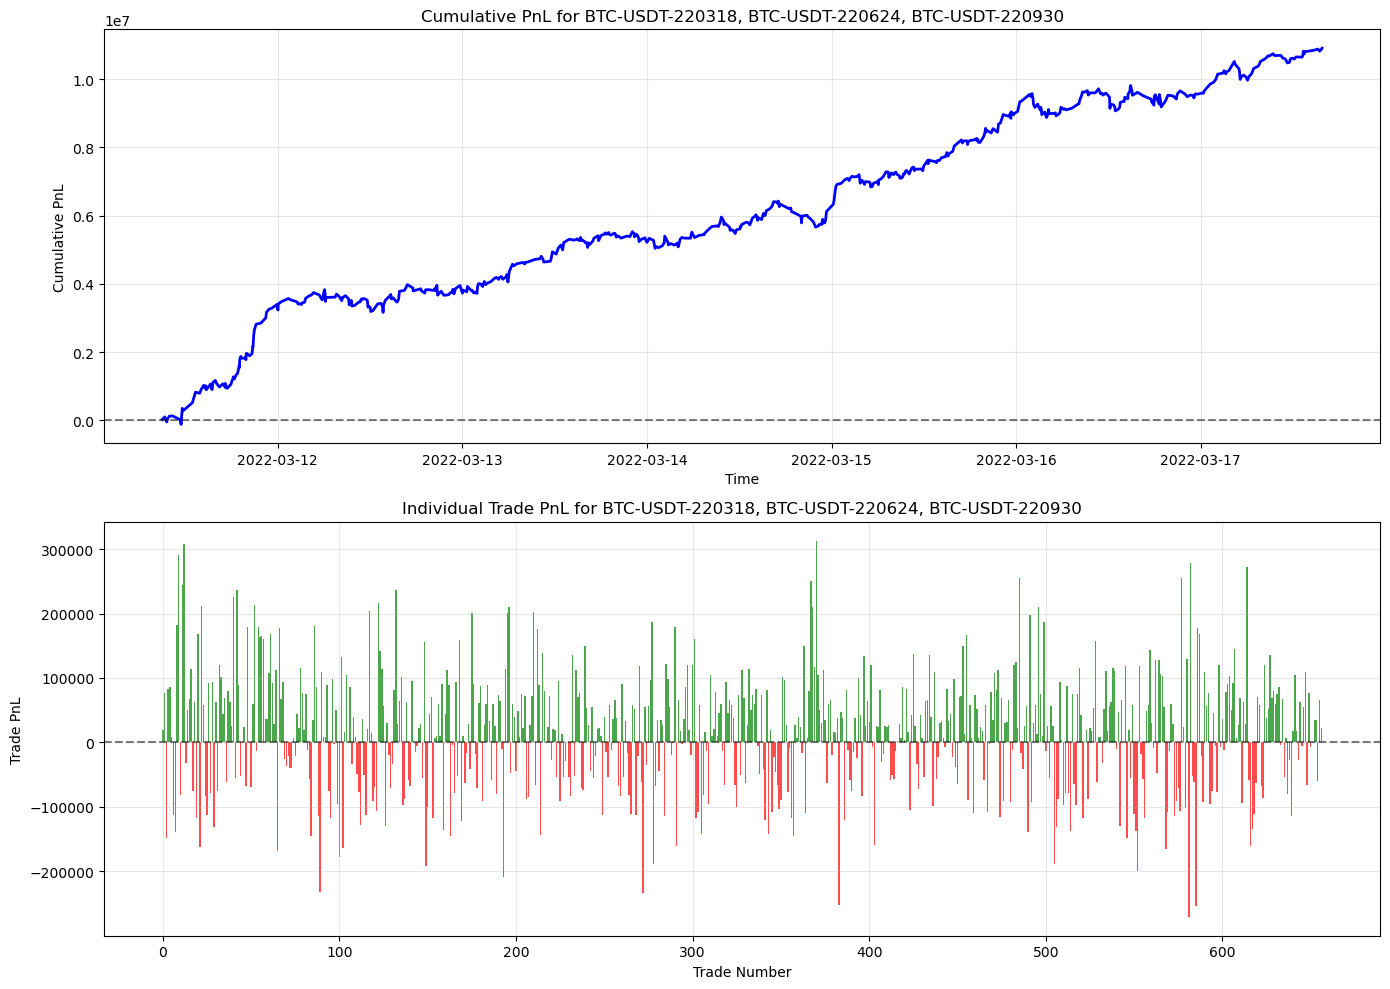

Statistics for BTC-USDT-220318, BTC-USDT-220624, BTC-USDT-220930:
  triplet: BTC-USDT-220318_BTC-USDT-220624_BTC-USDT-220930
  total_trades: 657
  total_pnl: 10914223.4421
  win_rate: 0.6088
  avg_pnl: 16612.2122
  ann_trade_sharpe: 3.4242
  mean_reversion_time: 1.3450
  median_reversion_time: 1.0000
  failure_rate: 0.4353
  avg_move: 1.6299
  avg_mae: 0.0085
  avg_mfe: 0.0638
  avg_edge_per_bar: 3714.5162



In [24]:
for idx, row in liquid_triplets_df.iterrows():
    t1, t2, t3 = row['tenor1_contract'], row['tenor2_contract'], row['tenor3_contract']

    triplet_df = butterfly_zcored[
        (butterfly_zcored['tenor1_contract'] == t1) &
        (butterfly_zcored['tenor2_contract'] == t2) &
        (butterfly_zcored['tenor3_contract'] == t3)
    ].copy()

    trades_df = butterfly_trading_strategy(triplet_df, transaction_cost_pct=0.0004, notional_per_leg=1_000_000)

    import matplotlib.pyplot as plt

    pnl_lower = trades_df['pnl'].quantile(0.005)
    pnl_upper = trades_df['pnl'].quantile(0.995)
    trades_df = trades_df[(trades_df['pnl'] >= pnl_lower) & (trades_df['pnl'] <= pnl_upper)].copy()
    
    if len(trades_df) > 0 and trades_df['pnl'].sum() > 0:
        trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum()
        
        plt.figure(figsize=(14, 8))
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        ax1.plot(trades_df['exit_time'], trades_df['cumulative_pnl'], linewidth=2, color='blue')
        ax1.set_title(f'Cumulative PnL for {t1}, {t2}, {t3}')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Cumulative PnL')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
        ax2.bar(range(len(trades_df)), trades_df['pnl'], color=colors, alpha=0.7)
        ax2.set_title(f'Individual Trade PnL for {t1}, {t2}, {t3}')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('Trade PnL')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.show()
        
        total_pnl = trades_df['pnl'].sum()
        win_rate = (trades_df['pnl'] > 0).mean()
        avg_pnl = trades_df['pnl'].mean()
        
        if trades_df['pnl'].std() > 0:
            ann_trade_sharpe = (trades_df['pnl'].mean() / trades_df['pnl'].std()) * np.sqrt(365)
        else:
            ann_trade_sharpe = 0
        
        stats_list = []
        for _, trade in trades_df.iterrows():
            trade_data = triplet_df[
                (triplet_df['timestamp'] >= trade['entry_time']) & 
                (triplet_df['timestamp'] <= trade['exit_time'])
            ].copy()
            
            if len(trade_data) > 0:
                if trade['position'] == 1: 
                    reversion_mask = trade_data['fly_value_zscore'] >= 0
                else:  
                    reversion_mask = trade_data['fly_value_zscore'] <= 0
                
                reversion_time = None
                if reversion_mask.any():
                    reversion_idx = trade_data[reversion_mask].index[0]
                    entry_idx = trade_data.index[0]
                    reversion_time = trade_data.loc[reversion_idx, 'timestamp'] - trade_data.loc[entry_idx, 'timestamp']
                    reversion_time = reversion_time.total_seconds() / 60  
                
                spread_move = abs(trade['exit_zscore'] - trade['entry_zscore'])
                
                if trade['position'] == 1:
                    max_adverse = (trade_data['fly_value_zscore'] - trade['entry_zscore']).min()
                    max_favorable = (trade_data['fly_value_zscore'] - trade['entry_zscore']).max()
                else:
                    max_adverse = (trade_data['fly_value_zscore'] - trade['entry_zscore']).max()
                    max_favorable = (trade_data['fly_value_zscore'] - trade['entry_zscore']).min()
                
                edge_per_bar = trade['pnl'] / len(trade_data) if len(trade_data) > 0 else 0
                trade_sharpe = trade['pnl'] / max(abs(max_adverse), 0.01)
                
                stats_list.append({
                    'reversion_time': reversion_time,
                    'spread_move': spread_move,
                    'max_adverse': max_adverse,
                    'max_favorable': max_favorable,
                    'edge_per_bar': edge_per_bar,
                    'trade_sharpe': trade_sharpe
                })
        
        stats_df = pd.DataFrame(stats_list)
        
        triplet_stats = {
            'triplet': f"{t1}_{t2}_{t3}",
            'total_trades': len(trades_df),
            'total_pnl': total_pnl,
            'win_rate': win_rate,
            'avg_pnl': avg_pnl,
            'ann_trade_sharpe': ann_trade_sharpe,
            'mean_reversion_time': stats_df['reversion_time'].dropna().mean() if len(stats_df) > 0 else np.nan,
            'median_reversion_time': stats_df['reversion_time'].dropna().median() if len(stats_df) > 0 else np.nan,
            'failure_rate': stats_df['reversion_time'].isna().mean() if len(stats_df) > 0 else np.nan,
            'avg_move': stats_df['spread_move'].mean() if len(stats_df) > 0 else np.nan,
            'avg_mae': stats_df['max_adverse'].mean() if len(stats_df) > 0 else np.nan,
            'avg_mfe': stats_df['max_favorable'].mean() if len(stats_df) > 0 else np.nan,
            'avg_edge_per_bar': stats_df['edge_per_bar'].mean() if len(stats_df) > 0 else np.nan,
        }
        
        print(f"Statistics for {t1}, {t2}, {t3}:")
        for key, value in triplet_stats.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            else:
                print(f"  {key}: {value}")
        print()